In [80]:
%matplotlib inline
import random
from skimage import io
from skimage.transform import resize

In [81]:
def IOU(A,B):
    x_overlap = max(0, min(B[0],B[2]) - max(A[0],A[2]))
    y_overlap = max(0, min(B[1],B[3]) - max(A[1],A[3]))
    inter = x_overlap * y_overlap;
    
    
#     x1 = max(A[0],B[0])
#     y1 = max(A[1],B[1])
#     x2 = min(A[2],B[2])
#     y2 = min(A[3],B[3])
    
#     w = x2 - x1 + 1
#     h = y2 - y1 + 1
    
#     if w<=0 or h<=0:
#         return 0
    
#     inter = w*h
    
    A_area = (A[2] - A[0] + 1)*(A[3] - A[1] + 1)
    B_area = (B[2] - B[0] + 1)*(B[3] - B[1] + 1)
    
    # print B[0],B[1]
    
    union = (A_area + B_area - inter)*1.0
    inter = inter*1.0
    
    return inter/union

In [82]:
base_dir = '/home/ayush/GPU_ML/ML/workspace/project/raw/'

win_size = 128


train_x_grp_1_pos = []
train_y_grp_1_pos = []

train_x_grp_2_pos = []
train_y_grp_2_pos = []

train_x_grp_3_pos = []
train_y_grp_3_pos = []

train_x_grp_4_pos = []
train_y_grp_4_pos = []

train_x_grp_5_pos = []
train_y_grp_5_pos = []

train_x_grp_1_neg = []
train_y_grp_1_neg = []

train_x_grp_2_neg = []
train_y_grp_2_neg = []

train_x_grp_3_neg = []
train_y_grp_3_neg = []

train_x_grp_4_neg = []
train_y_grp_4_neg = []

train_x_grp_5_neg = []
train_y_grp_5_neg = []

with open('bounding_boxes.csv','r') as f:
    f.readline()
    for line in f:
        data = line.strip().split(',')
        
        file_name = data[0]
        grp = int(file_name.split('_')[0]) - 1
        
        label_s = data[-1]
        
        x1,y1,x2,y2,label_i = map(int, data[1:])
        
        file_path = base_dir + label_s + '/' + file_name
        img = io.imread(file_path, as_grey = True)
        h,w = img.shape[:2]
        
        #  hand image
        imgg = img[y1:y2,x1:x2]
        imgg = resize(imgg, (win_size,win_size) )
        if grp%4 == 0:
            train_x_grp_1_pos.append(imgg)
            train_y_grp_1_pos.append(1)
        elif grp%2 == 1:
            train_x_grp_2_pos.append(imgg)
            train_y_grp_2_pos.append(1)
        elif grp%2 == 2:
            train_x_grp_3_pos.append(imgg)
            train_y_grp_3_pos.append(1)
        elif grp%2 == 3:
            train_x_grp_4_pos.append(imgg)
            train_y_grp_4_pos.append(1)
        elif grp%2 == 4:
            train_x_grp_5_pos.append(imgg)
            train_y_grp_5_pos.append(1)
        
        # non-hand image
        count = 0
        A = [x1,y1,x2,y2]
        
        while True:
            x1_r = random.randrange(0,w - win_size)
            y1_r = random.randrange(0,h - win_size)
            x2_r = x1_r + win_size
            y2_r = y1_r + win_size
            
            if y2_r >= h or x2_r>=w:
                continue
            
            B = [x1_r, y1_r, x2_r, y2_r]
            
            if IOU(A,B) < 0.1:
                if grp%4 == 0:
                    train_x_grp_1_neg.append(img[y1_r:y2_r,x1_r:x2_r])
                    train_y_grp_1_neg.append(0)
                elif grp%4 == 1:
                    train_x_grp_2_neg.append(img[y1_r:y2_r,x1_r:x2_r])
                    train_y_grp_2_neg.append(0)
                elif grp%4 == 2:
                    train_x_grp_3_neg.append(img[y1_r:y2_r,x1_r:x2_r])
                    train_y_grp_3_neg.append(0)
                elif grp%4 == 3:
                    train_x_grp_4_neg.append(img[y1_r:y2_r,x1_r:x2_r])
                    train_y_grp_4_neg.append(0)
                elif grp%4 == 4:
                    train_x_grp_5_neg.append(img[y1_r:y2_r,x1_r:x2_r])
                    train_y_grp_5_neg.append(0)
                
                
                count += 1
            
            if count >= 2:
                break

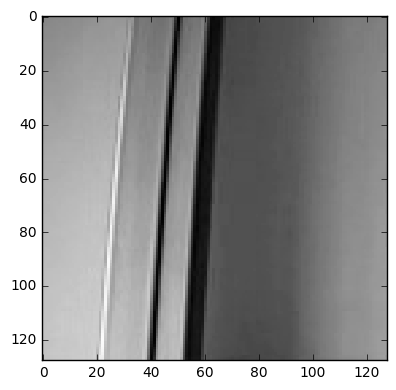

In [83]:
# print train_x_neg[1]
io.imshow(train_x_grp_1_neg[0])

In [84]:
from sklearn import svm
from skimage.feature import hog
import numpy as np

In [85]:
train_x_grp_1_pos_hog = map(lambda x : hog(x), train_x_grp_1_pos)
train_x_grp_2_pos_hog = map(lambda x : hog(x), train_x_grp_2_pos)
train_x_grp_3_pos_hog = map(lambda x : hog(x), train_x_grp_3_pos)
train_x_grp_4_pos_hog = map(lambda x : hog(x), train_x_grp_4_pos)
train_x_grp_5_pos_hog = map(lambda x : hog(x), train_x_grp_5_pos)

train_x_grp_1_neg_hog = map(lambda x : hog(x), train_x_grp_1_neg)
train_x_grp_2_neg_hog = map(lambda x : hog(x), train_x_grp_2_neg)
train_x_grp_3_neg_hog = map(lambda x : hog(x), train_x_grp_3_neg)
train_x_grp_4_neg_hog = map(lambda x : hog(x), train_x_grp_4_neg)
train_x_grp_5_neg_hog = map(lambda x : hog(x), train_x_grp_5_neg)

In [88]:
clf_1 = svm.LinearSVC()

train_x_1 = train_x_grp_2_pos_hog + train_x_grp_3_pos_hog + train_x_grp_4_pos_hog  \
+ train_x_grp_2_neg_hog + train_x_grp_3_neg_hog + train_x_grp_4_neg_hog

train_y_1 = train_y_grp_2_pos + train_y_grp_3_pos + train_y_grp_4_pos  \
+ train_y_grp_2_neg + train_y_grp_3_neg + train_y_grp_4_neg

val_x_1 = train_x_grp_1_pos_hog + train_x_grp_1_neg_hog
val_y_1 = train_y_grp_1_pos + train_y_grp_1_neg

clf_1.fit(np.asarray(train_x_1),np.asarray(train_y_1))

score_1 = clf_1.score(np.asarray(val_x_1), np.asarray(val_y_1))

print score_1

0.949333333333


In [90]:
clf_2 = svm.LinearSVC()

train_x_2 = train_x_grp_1_pos_hog + train_x_grp_3_pos_hog + train_x_grp_4_pos_hog \
+ train_x_grp_1_neg_hog + train_x_grp_3_neg_hog + train_x_grp_4_neg_hog

train_y_2 = train_y_grp_1_pos + train_y_grp_3_pos + train_y_grp_4_pos  \
+ train_y_grp_1_neg + train_y_grp_3_neg + train_y_grp_4_neg

val_x_2 = train_x_grp_2_pos_hog + train_x_grp_2_neg_hog
val_y_2 = train_y_grp_2_pos + train_y_grp_2_neg

clf_2.fit(np.asarray(train_x_2),np.asarray(train_y_2))

score_2 = clf_2.score(np.asarray(val_x_2), np.asarray(val_y_2))

print score_2

0.859


In [93]:
clf_3 = svm.LinearSVC()

train_x_3 = train_x_grp_1_pos_hog + train_x_grp_2_pos_hog + train_x_grp_4_pos_hog \
+ train_x_grp_1_neg_hog + train_x_grp_2_neg_hog + train_x_grp_4_neg_hog

train_y_3 = train_y_grp_1_pos + train_y_grp_2_pos + train_y_grp_4_pos  \
+ train_y_grp_1_neg + train_y_grp_2_neg + train_y_grp_4_neg

val_x_3 = train_x_grp_3_pos_hog + train_x_grp_3_neg_hog
val_y_3 = train_y_grp_3_pos + train_y_grp_3_neg 

clf_3.fit(np.asarray(train_x_3),np.asarray(train_y_3))

score_3 = clf_3.score(np.asarray(val_x_3), np.asarray(val_y_3))

print score_3

0.98


In [96]:
clf_4 = svm.LinearSVC()

train_x_4 = train_x_grp_1_pos_hog + train_x_grp_2_pos_hog + train_x_grp_3_pos_hog \
+ train_x_grp_1_neg_hog + train_x_grp_2_neg_hog + train_x_grp_3_neg_hog

train_y_4 = train_y_grp_1_pos + train_y_grp_2_pos + train_y_grp_3_pos  \
+ train_y_grp_1_neg + train_y_grp_2_neg + train_y_grp_3_neg

val_x_4 = train_x_grp_4_pos_hog + train_x_grp_4_neg_hog
val_y_4 = train_y_grp_4_pos + train_y_grp_4_neg

clf_4.fit(np.asarray(train_x_4),np.asarray(train_y_4))

score_4 = clf_4.score(np.asarray(val_x_4), np.asarray(val_y_4))

print score_4

print 'Average : %f' %((score_1 + score_2 + score_3 + score_4)/4)

0.984
Average : 0.943083
